In [1]:
%run __init__.py

In [5]:
from keras.utils import to_categorical


ModuleNotFoundError: No module named 'keras'

In [ ]:
import pandas as pd
import numpy as np
from joblib import dump, load
# from word2vec import make_model, class_weights_ohe

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [1]:
from gensim.models import Word2Vec

In [2]:
df_news = pd.read_csv('./data/apple_news_cleaned.csv.gz')

NameError: name 'pd' is not defined

## MODELING

In [8]:
sentences = apple_news_df['articles'].apply(lambda x: x.split()).to_list()
max_lenght = 100

In [9]:
l_encoder = LabelEncoder()
y_encoded = l_encoder.fit_transform(apple_news_df['sentiment'])

In [475]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(apple_news_df['sentiment'].values.reshape(-1,1))

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(apple_news_df['articles'])
sequences = tokenizer.texts_to_sequences(apple_news_df['articles'])
word_index = tokenizer.word_index
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer.word_index) + 1
data = pad_sequences(sequences, max_lenght)
labels = to_categorical(y_encoded)

In [11]:
print(f"{'Unique Words':25} {len(tokenizer.index_word)}")
print(f"{'Shape of data tensor':25} {data.shape}")
print(f"{'Shape of label tensor':25} {labels.shape}")

Unique Words              36827
Shape of data tensor      (9451, 100)
Shape of label tensor     (9451, 2)


In [12]:
word2vec = Word2Vec(sentences,
                     size=max_lenght,
                     window=5,
                     min_count=1,
                     workers=4,
                    )
word2vec.train(sentences, total_examples=word2vec.corpus_count, epochs=5)

pretrained_weights = word2vec.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape

vectors = np.asarray(word2vec.wv.vectors)

In [11]:
word2vec.save('./word2vec/word2vrc_model')

In [13]:
len(word_index), len(word2vec.wv.vocab)

(36827, 36827)

In [14]:
embedding_matrix = np.zeros((vocab_size+1, emdedding_size))
for word, idx in word_index.items():
        embedding_matrix[idx] = word2vec.wv[word]

dump(embedding_matrix, './word2vec/embedding_matrix.pkl', compress=5)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)
X_train, X_val, y_train, y_val   = train_test_split(data, labels, test_size=.15, random_state=1, stratify=labels)

print(f"Train\n\t{'X :':5}{X_train.shape}\n\t{'Y :':5}{y_train.shape}")
print(f"Test\n\t{'X :':5}{X_test.shape}\n\t{'Y :':5}{y_test.shape}")
print(f"Validation\n\t{'X :':5}{X_val.shape}\n\t{'Y :':5}{y_val.shape}")

Train
	X :  (8033, 100)
	Y :  (8033, 2)
Test
	X :  (1418, 100)
	Y :  (1418, 2)
Validation
	X :  (1418, 100)
	Y :  (1418, 2)


In [16]:
input_dim = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = data.shape[1]

In [217]:
BIAS = class_weights_ohe(labels)
METRICS = ['accuracy']
EPOCHS = 32
BATCH_SIZE = 400
STEPS_x_EPOCH = X_train.shape[0]//BATCH_SIZE

In [230]:
eStop_Val_Loss = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Loss     = EarlyStopping(monitor='loss', min_delta=0.001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Accuracy = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)
eStop_Val_accuracy  = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)

eStop_Reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.000001, verbose=1)

In [201]:
keras.backend.clear_session()

In [202]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )

In [203]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [204]:
model.layers[0].embeddings_initializer = keras.initializers.GlorotUniform()
model.layers[3].activation = tf.keras.activations.swish

In [198]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=[eStop_Val_accuracy, eStop_Val_Loss],
                    workers=6
                    )

Epoch 1/32
20/20 [==============================] - 23s 906ms/step - loss: 2.7740 - accuracy: 0.1187 - val_loss: 0.9841 - val_accuracy: 0.1206
Epoch 2/32
20/20 [==============================] - 17s 848ms/step - loss: 0.9613 - accuracy: 0.4958 - val_loss: 0.3819 - val_accuracy: 0.8794
Epoch 3/32
20/20 [==============================] - 17s 859ms/step - loss: 0.6506 - accuracy: 0.7170 - val_loss: 0.3675 - val_accuracy: 0.8794
Epoch 4/32
20/20 [==============================] - 17s 859ms/step - loss: 0.6192 - accuracy: 0.7569 - val_loss: 0.3707 - val_accuracy: 0.8794
Epoch 5/32
20/20 [==============================] - 17s 867ms/step - loss: 0.6102 - accuracy: 0.7637 - val_loss: 0.3662 - val_accuracy: 0.8794
Epoch 6/32
20/20 [==============================] - 17s 877ms/step - loss: 0.5447 - accuracy: 0.7821 - val_loss: 0.3596 - val_accuracy: 0.8794
Epoch 7/32
20/20 [==============================] - 17s 882ms/step - loss: 0.5343 - accuracy: 0.7923 - val_loss: 0.3470 - val_accuracy: 0.8794

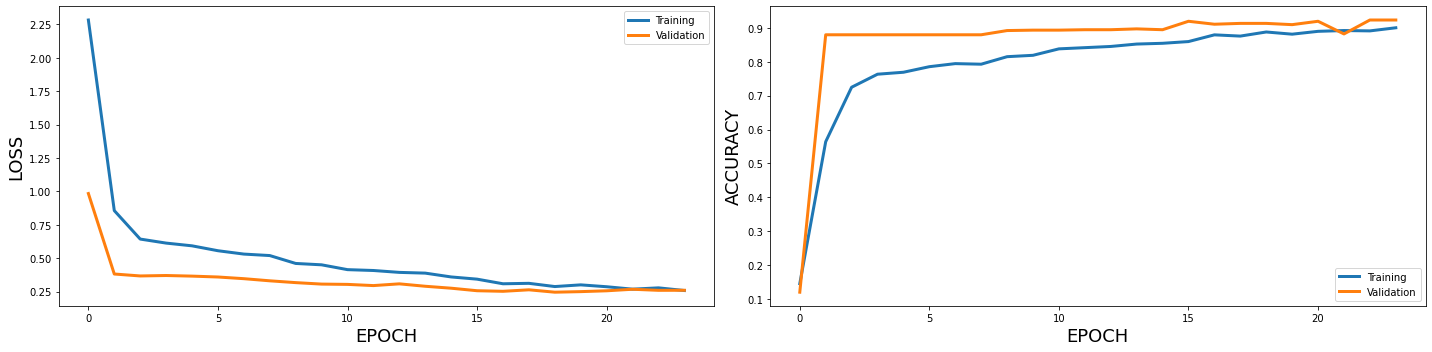

In [199]:
plot_model.plot_history(history)

In [211]:
# model.save_weights('./word2vec/train1')

In [225]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [226]:
model.layers[0].embeddings_initializer = keras.initializers.zeros()
model.layers[3].activation = tf.keras.activations.swish

In [227]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=[eStop_Val_Loss, eStop_Val_accuracy],
                    workers=6
                    )

Epoch 1/32
20/20 [==============================] - 22s 899ms/step - loss: 2.5789 - accuracy: 0.1415 - val_loss: 0.7471 - val_accuracy: 0.6580
Epoch 2/32
20/20 [==============================] - 17s 849ms/step - loss: 0.8351 - accuracy: 0.5657 - val_loss: 0.3451 - val_accuracy: 0.8794
Epoch 3/32
20/20 [==============================] - 17s 849ms/step - loss: 0.5721 - accuracy: 0.7748 - val_loss: 0.3359 - val_accuracy: 0.8930
Epoch 4/32
20/20 [==============================] - 17s 856ms/step - loss: 0.4916 - accuracy: 0.8071 - val_loss: 0.3187 - val_accuracy: 0.8955
Epoch 5/32
20/20 [==============================] - 17s 863ms/step - loss: 0.4629 - accuracy: 0.8184 - val_loss: 0.3133 - val_accuracy: 0.8980
Epoch 6/32
20/20 [==============================] - 17s 870ms/step - loss: 0.4697 - accuracy: 0.8208 - val_loss: 0.3113 - val_accuracy: 0.8955
Epoch 7/32
20/20 [==============================] - 17s 871ms/step - loss: 0.4490 - accuracy: 0.8281 - val_loss: 0.3028 - val_accuracy: 0.8955

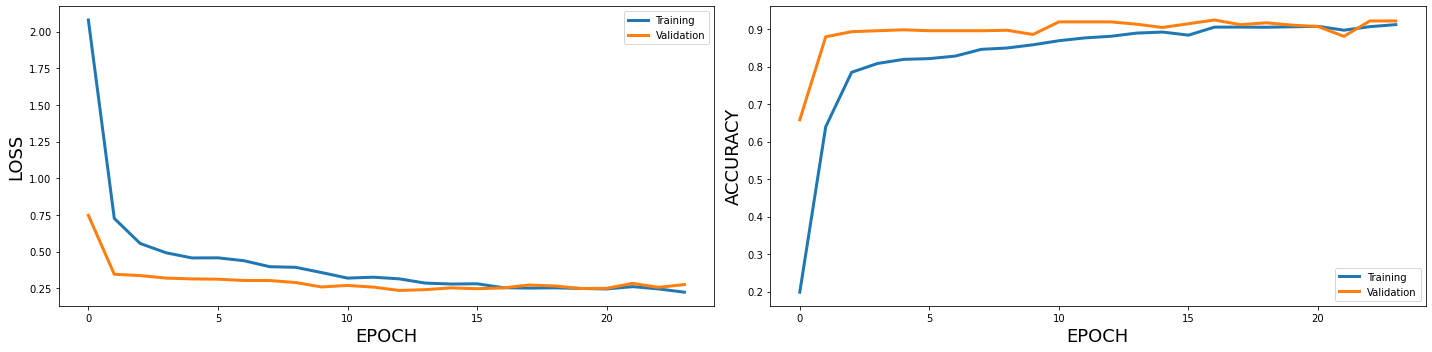

In [228]:
plot_model.plot_history(history)

In [229]:
model.save_weights('./word2vec/train2')

In [244]:
model = make_model(metrics=METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                   output_bias=BIAS
                  )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3682800   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 2)                 34        
Total params: 3,857,794
Trainable params: 174,994
Non-trainable params: 3,682,800
________________________________________

In [245]:
model.layers[0].embeddings_initializer = keras.initializers.zeros()
model.layers[3].activation = tf.keras.activations.relu

In [246]:
EPOCHS = 64

In [247]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
#                     steps_per_epoch=STEPS_x_EPOCH,
                    use_multiprocessing = True,
                    callbacks=eStop_Reduce_lr,
                    workers=6
                    )

Epoch 1/64
19/19 [==============================] - 22s 931ms/step - loss: 2.9623 - accuracy: 0.1180 - val_loss: 1.5058 - val_accuracy: 0.1206
Epoch 2/64
19/19 [==============================] - 16s 887ms/step - loss: 1.4210 - accuracy: 0.3540 - val_loss: 0.5506 - val_accuracy: 0.7861
Epoch 3/64
19/19 [==============================] - 16s 874ms/step - loss: 0.9085 - accuracy: 0.6133 - val_loss: 0.4167 - val_accuracy: 0.7848
Epoch 4/64
19/19 [==============================] - 17s 888ms/step - loss: 0.7452 - accuracy: 0.6981 - val_loss: 0.3691 - val_accuracy: 0.8010
Epoch 5/64
19/19 [==============================] - 17s 901ms/step - loss: 0.6728 - accuracy: 0.7384 - val_loss: 0.3739 - val_accuracy: 0.8968
Epoch 6/64
19/19 [==============================] - 17s 914ms/step - loss: 0.6230 - accuracy: 0.7760 - val_loss: 0.3641 - val_accuracy: 0.8955
Epoch 7/64
19/19 [==============================] - 17s 904ms/step - loss: 0.5938 - accuracy: 0.7883 - val_loss: 0.3392 - val_accuracy: 0.8968

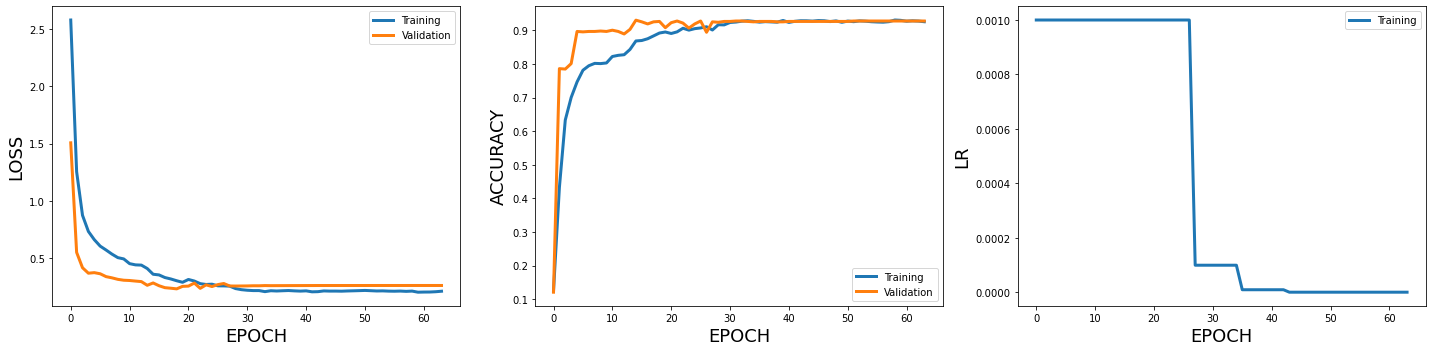

In [570]:
plot_model.plot_history(history)

In [249]:
model.save_weights('./word2vec/word2vec')

In [264]:
score = model.evaluate(X_test, y_test, batch_size=1, steps=X_test.shape[0], workers=8, verbose=0)

In [269]:
y_pred = model.predict(X_test, batch_size=1,verbose=0)

In [572]:
print('Accuracy :', score[1])

Accuracy : 0.928067684173584


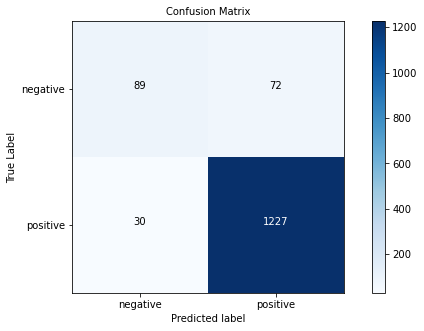

In [571]:
plot_model.confusion_matrix(y_true=y_test, y_pred=y_pred, target_name=ohe.categories_[0], file_name='./img/cm.jpg')

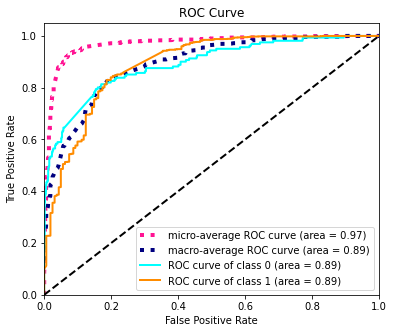

In [573]:
plot_model.plot_roc_curve(y_true=y_test, y_pred=y_pred, file_name='./img/roc.jpg')